In [2]:
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import os 
import numpy as np
from sklearn.cluster import DBSCAN

In [3]:
year = 2018
month=1
day=1
#data/2018/RR_IDF300x300_20180101.npy
path = os.path.join(os.path.dirname(os.getcwd()),'data','{:04d}'.format(year))
file = 'RR_IDF300x300_{:04d}{:02d}{:02d}.npy'.format(year,month,day)
file = os.path.join(path,file)

RR = np.load(file)/100.0
RR[RR < 0]=np.nan


In [4]:
def dtw_distance(x, y):
    distance, _ = fastdtw(x, y)
    return distance

## approche par PDynamique

In [ ]:
def calculate_distance_matrix(RR=RR, x_start=0, x_end=10, y_start=0, y_end=10, distance_function=dtw_distance):
    selected_data = RR[:, x_start:x_end, y_start:y_end]
    
    num_series = selected_data.shape[1] * selected_data.shape[2]
    
    # Initialisation de la matrice des distances
    distance_matrix = np.zeros((num_series, num_series))
    
    # Remplissage de la matrice des distances
    for i in range(num_series):
        for j in range(i + 1, num_series):  # Pas besoin de calculer la diagonale et symétrique
            x_i, y_i = divmod(i, selected_data.shape[2])
            x_j, y_j = divmod(j, selected_data.shape[2])
            ts1 = selected_data[:, x_i, y_i]
            ts2 = selected_data[:, x_j, y_j]
            distance = distance_function(ts1, ts2)
            distance_matrix[i, j] = distance_matrix[j, i] = distance
    
    return distance_matrix


: 

44.75999999999992 28.067681999999994


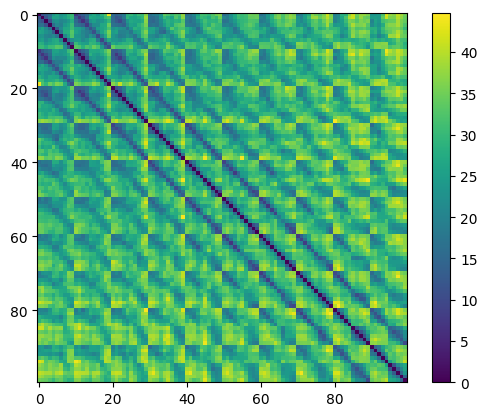

In [5]:
distance_matrix = calculate_distance_matrix(RR, 0, 10, 0, 10, dtw_distance)
print(distance_matrix.max(),distance_matrix.mean())
plt.imshow(distance_matrix)
plt.colorbar()

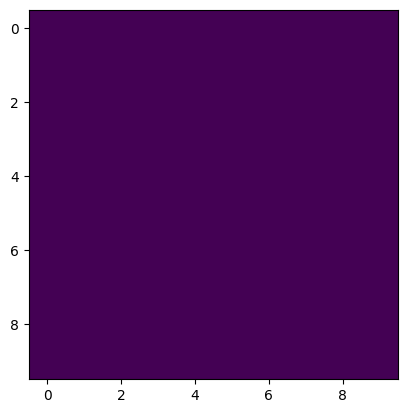

In [6]:
dbscan_dynamic = DBSCAN(eps=30, min_samples=4, metric='precomputed')
dbscan_dynamic.fit(distance_matrix)
labels=dbscan_dynamic.labels_
plt.imshow(labels.reshape(10,10))

## approche classic par DBSCAN SKLEARN

## Sliding window

In [1]:
longitude_max = 2 
latitude_max = 2 
step = 9 
width = 10  

In [5]:
dbscan = DBSCAN(eps=2, min_samples=2, metric=dtw_distance)

# Adapter la taille et les indices en fonction de la structure de RR
dict_clusters = {}
dict_labels = {}
core_points = {}

for i in range(longitude_max):
    for j in range(latitude_max):
        data = RR[:, i*step:width+i*step, j*step:width+j*step].reshape(-1, 288) 
        dbscan.fit(data)
        cluster_key = f"cluster({i},{j})"
        label_key = f"labels({i},{j})"
        core_points_key=f"core_points({i},{j})"
        dict_clusters[cluster_key] = dbscan
        dict_labels[label_key] = dbscan.labels_.reshape(width, width)
        core_points[core_points_key] = dbscan.core_sample_indices_



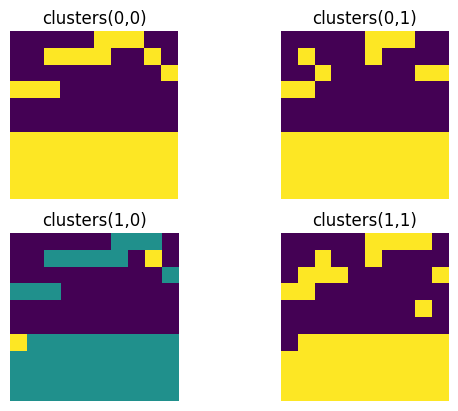

In [6]:

fig, axs = plt.subplots(longitude_max, latitude_max)  # 2 rows, 2 columns

# Display images on each subplot
for i in range(longitude_max):
    for j in range(latitude_max):
        
        axs[i, j].imshow(dict_labels[f"labels({i},{j})"])
        axs[i, j].set_title(f'clusters({i},{j})')
        axs[i, j].axis('off')  

plt.show()

In [7]:
def traduction_core_points_map(step,width,i,j,core_points):
    points_groupe=[]
    points_map=[]
    for point in core_points:
        points_groupe.append({"x_groupe":point%width,"y_groupe":point//width})
        points_map.append({"x_map":i*step+point%width,"y_map":j*step+point//width})
    return points_groupe,points_map

In [8]:
import copy

dict=copy.deepcopy(dict_labels)

In [9]:
def merge_clusters_if_shared_core_point(i1, j1, i2, j2, core_points, dict, step, width,running_max_label):
    # Retrieve core points and labels
    core_points_1 = core_points[f"core_points({i1},{j1})"]
    core_points_2 = core_points[f"core_points({i2},{j2})"]
    
    labels_1 = dict[f"labels({i1},{j1})"]
    labels_2 = dict[f"labels({i2},{j2})"]
    
    # Translate core points to map coordinates
    _, points_map1 = traduction_core_points_map(step, width, i1, j1, core_points_1)
    _, points_map2 = traduction_core_points_map(step, width, i2, j2, core_points_2)
    
    # Find common core points
    set_core_points1 = {tuple(point.values()) for point in points_map1}
    set_core_points2 = {tuple(point.values()) for point in points_map2}
    common_core_points = set_core_points1.intersection(set_core_points2)
    
    # Assign new labels for common core points
    for point in common_core_points:
        point_group1 = (point[0] - i1 * step, point[1] - j1 * step)
        point_group2 = (point[0] - i2 * step, point[1] - j2 * step)
    
        label_1 = labels_1[point_group1[0],point_group1[1]]
        label_2 = labels_2[point_group2[0],point_group2[1]]
    
        if label_1 != label_2 and label_1 is not None and label_2 is not None:
            for i in range(labels_2.shape[0]):
                for j in range(labels_2.shape[1]):
                    if labels_2[i, j] == label_2:
                        labels_2[i, j] = label_1


    # Assign new labels for non-common but in the second group to merge
    for point in set_core_points2 - common_core_points:
        point_group = (point[0] - i2 * step, point[1] - j2 * step)
        if True:
            label_to_change = labels_2[point_group[0],point_group[1]]
            for i in range(labels_2.shape[0]):
                for j in range(labels_2.shape[1]):
                    if labels_2[i, j] == label_to_change:
                        labels_2[i, j] = running_max_label
            running_max_label += 1

    # Merge the updated labels back into the main label dictionary
    dict[f"labels({i1},{j1})"] = labels_1
    dict[f"labels({i2},{j2})"] = labels_2

    return running_max_label, dict


In [10]:
def merge_clusters_if_shared_core_point(i1, j1, i2, j2, core_points,dict, step, width, running_max_label, processed_labels):
    # Retrieve core points and labels
    core_points_1 = core_points[f"core_points({i1},{j1})"]
    core_points_2 = core_points[f"core_points({i2},{j2})"]
    
    labels_1 = dict[f"labels({i1},{j1})"]
    labels_2 = dict[f"labels({i2},{j2})"]
    
    # Translate core points to map coordinates
    _, points_map1 = traduction_core_points_map(step, width, i1, j1, core_points_1)
    _, points_map2 = traduction_core_points_map(step, width, i2, j2, core_points_2)
    
    # Find common core points
    set_core_points1 = {tuple(point.values()) for point in points_map1}
    set_core_points2 = {tuple(point.values()) for point in points_map2}
    common_core_points = set_core_points1.intersection(set_core_points2)
    
    # Assign new labels for common core points
    for point in common_core_points:
        point_group1 = (point[0] - i1 * step, point[1] - j1 * step)
        point_group2 = (point[0] - i2 * step, point[1] - j2 * step)
    
        label_1 = labels_1[point_group1[0], point_group1[1]]
        label_2 = labels_2[point_group2[0], point_group2[1]]
    
        if label_1 != label_2 and label_1 is not None and label_2 is not None:
            for i in range(labels_2.shape[0]):
                for j in range(labels_2.shape[1]):
                    if labels_2[i, j] == label_2:
                        labels_2[i, j] = label_1
            # Add the processed label to the set
            processed_labels.add(label_2)

    # Assign new labels for non-common points in the second group
    for point in set_core_points2 - common_core_points:
        point_group = (point[0] - i2 * step, point[1] - j2 * step)
        label_to_change = labels_2[point_group[0], point_group[1]]
        
        # Skip if the label has already been processed
        if label_to_change not in processed_labels:
            for i in range(labels_2.shape[0]):
                for j in range(labels_2.shape[1]):
                    if labels_2[i, j] == label_to_change:
                        labels_2[i, j] = running_max_label
            # Add the processed label to the set
            processed_labels.add(label_to_change)
            running_max_label += 1

    # Merge the updated labels back into the main label dictionary
    dict[f"labels({i1},{j1})"] = labels_1
    dict[f"labels({i2},{j2})"] = labels_2

    return running_max_label,dict

In [11]:
merge_clusters_if_shared_core_point(0, 0, 0, 1, core_points, dict, step, width,4,set())

(51,
 {'labels(0,0)': array([[-1, -1, -1, -1, -1,  0,  0,  0, -1, -1],
         [-1, -1,  0,  0,  0,  0, -1, -1,  0, -1],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1,  0],
         [ 0,  0,  0, -1, -1, -1, -1, -1, -1, -1],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64),
  'labels(0,1)': array([[49, 49, 49, 49, 49, 50, 50, 50, 49, 49],
         [49, 50, 49, 49, 49, 50, 49, 49, 49, 49],
         [49, 49, 50, 49, 49, 49, 49, 49, 50, 50],
         [50, 50, 49, 49, 49, 49, 49, 49, 49, 49],
         [49, 49, 49, 49, 49, 49, 49, 49, 49, 49],
         [49, 49, 49, 49, 49, 49, 49, 49, 49, 49],
         [50, 50, 50, 50, 50, 50, 50, 50, 50, 50],
         [50, 50, 50, 50, 50, 50, 50, 50, 50, 50],
         [50, 50, 50, 50, 50, 50

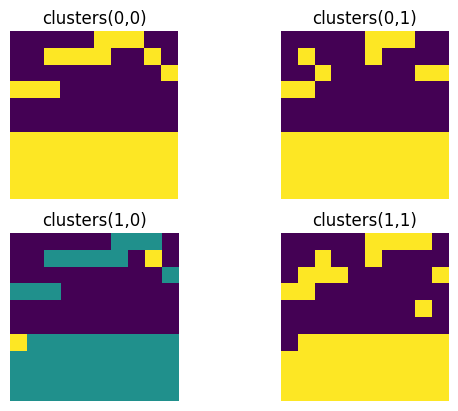

In [13]:

fig, axs = plt.subplots(longitude_max, latitude_max)  # 2 rows, 2 columns

# Display images on each subplot
for i in range(longitude_max):
    for j in range(latitude_max):
        
        axs[i, j].imshow(dict[f"labels({i},{j})"])
        axs[i, j].set_title(f'clusters({i},{j})')
        axs[i, j].axis('off')  # Hide axes for cleaner look

plt.show()